Reference: Kaggle 

Exploring Player Stats¶
Author: Eric Couto
Date: 17 July 2016
Topics:
Loading Data
Player Tables
t-SNE of Players (FIFA Stats)
Evolution of the Best Players (top 20)

In [4]:
import sqlite3
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from bokeh.plotting import figure, ColumnDataSource, show
from bokeh.models import HoverTool
from bokeh.io import output_notebook
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
output_notebook()

database ='database.sqlite'
conn = sqlite3.connect(database)

query = "SELECT name FROM sqlite_master WHERE type='table';"
pd.read_sql(query, conn)

Loading BokehJS ...

,name
0,Country
1,sqlite_sequence
2,League
3,Match
4,Player
5,Player_Stats
6,Team


In [5]:
# Check the player tables
query = "SELECT * FROM Player;"
player = pd.read_sql(query, conn)
player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [6]:
# Check the player stats table
query = "SELECT * FROM Player_Stats;"
player_stats = pd.read_sql(query, conn)
player_stats.head()

,id,player_fifa_api_id,player_api_id,date_stat,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [8]:
query = """SELECT * FROM Player_Stats a
            INNER JOIN(SELECT player_name, player_api_id AS p_id FROM Player) b ON a.player_api_id = b.p_id;
"""
drop_cols = ['id','player_fifa_api_id','date_stat','preferred_foot','attacking_work_rate','defensive_work_rate']

players = pd.read_sql(query, conn)
players['date_stat'] = pd.to_datetime(players['date_stat'])
players = players[players.date_stat > pd.datetime(2015,1,1)]
players = players[~players.overall_rating.isnull()].sort_values('date_stat', ascending=False)
players = players.drop_duplicates(subset='player_api_id',keep='first')
players = players.drop(drop_cols, axis=1)

players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7676 entries, 1312 to 76345
Data columns (total 38 columns):
player_api_id         7676 non-null int64
overall_rating        7676 non-null float64
potential             7676 non-null float64
crossing              7676 non-null float64
finishing             7676 non-null float64
heading_accuracy      7676 non-null float64
short_passing         7676 non-null float64
volleys               7676 non-null float64
dribbling             7676 non-null float64
curve                 7676 non-null float64
free_kick_accuracy    7676 non-null float64
long_passing          7676 non-null float64
ball_control          7676 non-null float64
acceleration          7676 non-null float64
sprint_speed          7676 non-null float64
agility               7676 non-null float64
reactions             7676 non-null float64
balance               7676 non-null float64
shot_power            7676 non-null float64
jumping               7676 non-null float64
stamina    

In [9]:
players = players.fillna(0)

cols = ['player_api_id','player_name','overall_rating','potential']
stats_cols = [col for col in players.columns if col not in (cols)]

ss = StandardScaler()
tmp = ss.fit_transform(players[stats_cols])
model = TSNE(n_components=2, random_state=0)
tsne_comp = model.fit_transform(tmp)

In [10]:
tmp = players[cols]
tmp['comp1'], tmp['comp2'] = tsne_comp[:,0], tsne_comp[:,1]
tmp = tmp[tmp.overall_rating >= 80]

_tools = 'box_zoom,pan,save,resize,reset,tap,wheel_zoom'
fig = figure(tools=_tools, title='t-SNE of Players(FIFA stats)', responsive=True,x_axis_label='Component 1',y_axis_label='Component 2')

source = ColumnDataSource(tmp)
hover = HoverTool()
hover.tooltips=[('Jogador','@player_name'),]
fig.scatter(tmp['comp1'], tmp['comp2'], source=source, size=8, alpha=0.6, line_color='red', fill_color='red')

fig.add_tools(hover)

show(fig)

/Users/zhaoxiaoxing/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


/Users/zhaoxiaoxing/anaconda/envs/py3k/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


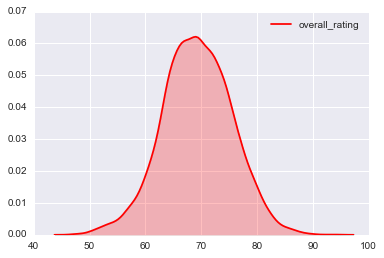

In [11]:
sns.kdeplot(players.overall_rating, shade=True, color="r")

/Users/zhaoxiaoxing/anaconda/envs/py3k/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


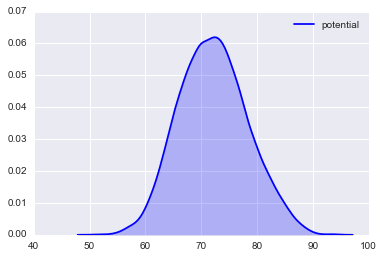

In [12]:
sns.kdeplot(players.potential, shade=True, color="blue")

/Users/zhaoxiaoxing/anaconda/envs/py3k/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


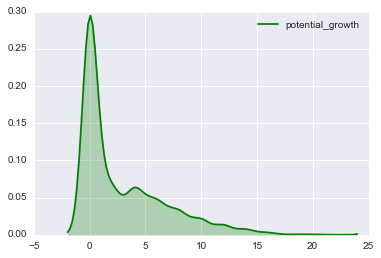

In [13]:
players['potential_growth'] = players.potential - players.overall_rating
sns.kdeplot(players.potential_growth, shade=True, color="green")

In [16]:
tmp = players[cols]
tmp['comp1'], tmp['comp2'] = tsne_comp[:,0], tsne_comp[:,1]
tmp['potential_growth'] = tmp.potential - tmp.overall_rating
tmp = tmp[(tmp.potential_growth >= 5) & (tmp.overall_rating >= 75)]

_tools = 'box_zoom,pan,save,resize,reset,tap,wheel_zoom'
fig = figure(tools=_tools, title='t-SNE of Potential Top Players (FIFA stats)', responsive=True, 
            x_axis_label='Component 1', y_axis_label = 'Component 2')

source = ColumnDataSource(tmp)
hover = HoverTool()
hover.tooltips=[('Jogador','@player_name'),]
fig.scatter(tmp['comp1'], tmp['comp2'], source=source, size=8, alpha=0.6, line_color='red',fill_color='red')

fig.add_tools(hover)
show(fig)

/Users/zhaoxiaoxing/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/zhaoxiaoxing/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [19]:
players = players.sort_values("overall_rating", ascending=False)
best_players = players[['player_api_id','player_name']].head(20)
ids = tuple(best_players.player_api_id.unique())

query = '''
            SELECT player_api_id, date_stat, overall_rating, potential 
            FROM Player_Stats WHERE player_api_id in %s
    ''' %(ids,)
evolution = pd.read_sql(query, conn)
evolution = pd.merge(evolution, best_players)
evolution['year'] = evolution.date_stat.str[:4].apply(int)
evolution = evolution.groupby(['year','player_api_id','player_name']).overall_rating.mean()
evolution = evolution.reset_index()

evolution.head()

,year,player_api_id,player_name,overall_rating
0,2007,19533,Neymar,73.0
1,2007,27299,Manuel Neuer,72.0
2,2007,30834,Arjen Robben,87.0
3,2007,30893,Cristiano Ronaldo,89.0
4,2007,30894,Philipp Lahm,85.5


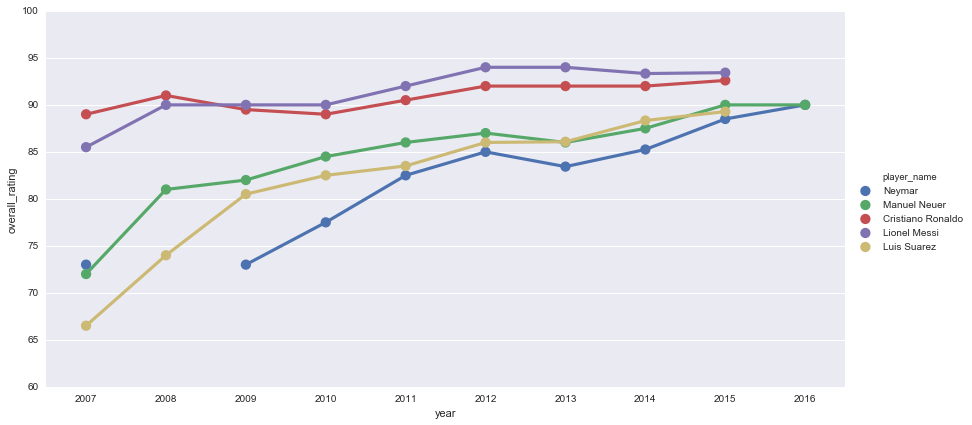

In [20]:
top5_players = sns.factorplot(data=evolution[evolution.player_api_id.isin(ids[0:5])], x='year',y='overall_rating',
                             hue='player_name', size=6, aspect=2)

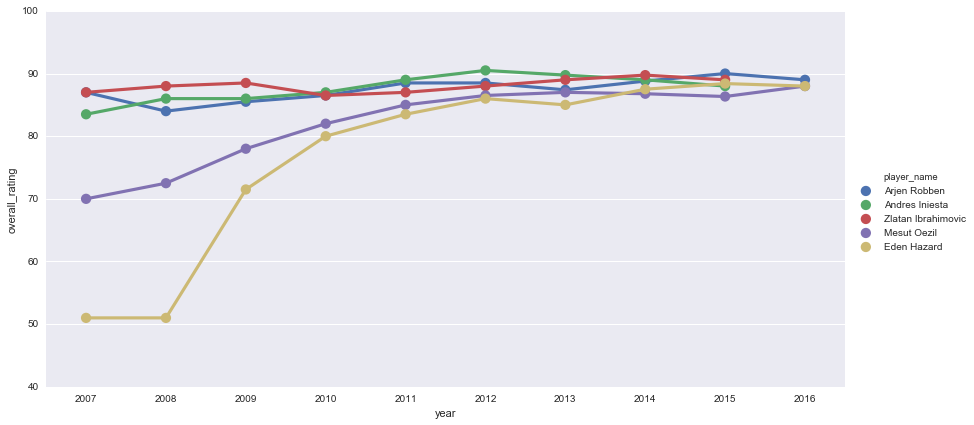

In [21]:
top5_to_10 = sns.factorplot(data=evolution[evolution.player_api_id.isin(ids[5:10])],x='year',
                           y='overall_rating',hue='player_name',size=6, aspect=2)

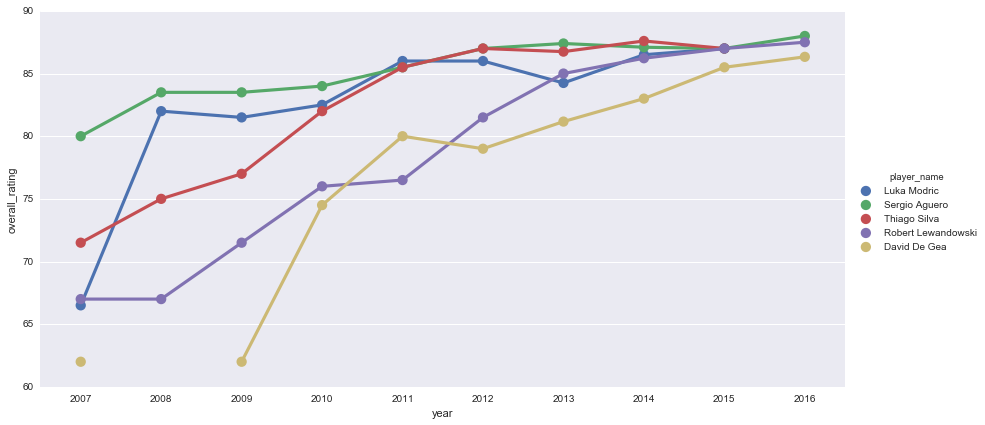

In [22]:
top10_to_15 = sns.factorplot(data=evolution[evolution.player_api_id.isin(ids[10:15])],x='year',
                            y='overall_rating',hue='player_name',size=6, aspect=2)

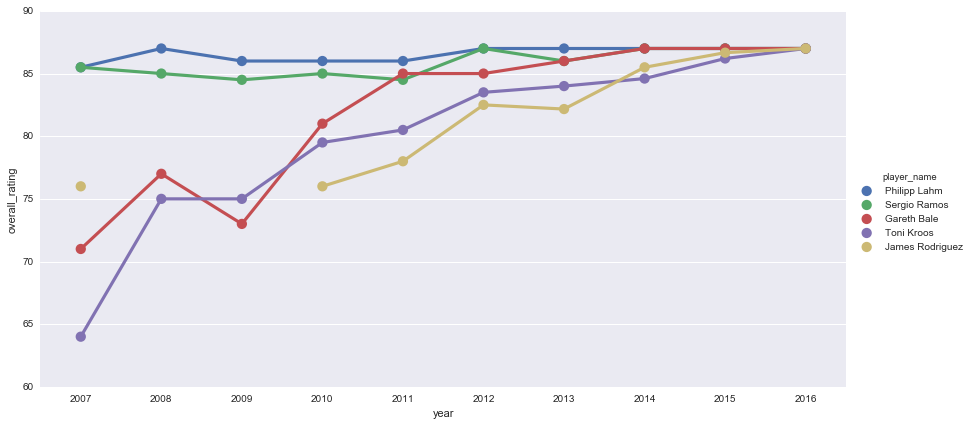

In [23]:
top15_to_20 = sns.factorplot(data=evolution[evolution.player_api_id.isin(ids[15:20])], x='year',
                            y='overall_rating', hue='player_name', size=6, aspect=2)